### Introduction

This project examines the tweet archive for WeRateDogs to draw insights from the dataset regarding the ratings of dogs. The Gather, Assess and Clean process is followed with the aim of answering the following questions:

- What type of dogs have the highest ratings?
- What type of dogs are the most popular in terms of retweet count and favorite count?
- What dog stage has the highest ratings?

## Gather

In [1]:
import json
import numpy as np
import os
import pandas as pd
import re
import requests
import tweepy
from timeit import default_timer as timer
from tweepy import OAuthHandler

%matplotlib inline

In [2]:
# Load twitter archive file
archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Download image-predictions file
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

In [4]:
# Import image predictions file
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_enhanced.tweet_id.values
len(tweet_ids)

2356

In [7]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
if not os.path.exists('tweet_json.txt'):
    count = 0
    fails_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)


In [8]:
# DELETE
# Temp - save fails_dict to file for working with
'''
import csv
fails_list = []
for key in fails_dict.keys():
    fails_list.append(key)
fails_list
with open('fails_dict.csv', 'w') as outfile:
    wr = csv.writer(outfile, dialect='excel')
    wr.writerow(fails_list)
'''

"\nimport csv\nfails_list = []\nfor key in fails_dict.keys():\n    fails_list.append(key)\nfails_list\nwith open('fails_dict.csv', 'w') as outfile:\n    wr = csv.writer(outfile, dialect='excel')\n    wr.writerow(fails_list)\n"

In [9]:
# DELETE
# Working - uncomment out if necessary
'''
failures = []
with open('fails_dict.csv', 'r') as f:
    reader = csv.reader(f)
    for line in reader:
        failures.append(line)
'''

"\nfailures = []\nwith open('fails_dict.csv', 'r') as f:\n    reader = csv.reader(f)\n    for line in reader:\n        failures.append(line)\n"

In [10]:
# Load extended tweet data
tweets = []
with open('tweet_json.txt') as json_file:
    for line in json_file:
        tweets.append(json.loads(line))

# Place extended tweet data into a dataframe
extended_data = pd.DataFrame(tweets)

## Assess

In [11]:
# View column types and missing data in twitter_archive_enhanced
archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# Visually assess data in archive
archive_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1693,681297372102656000,NaN,NaN,2015-12-28 02:15:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is actually a lion. We only rate dogs. Fo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681297372...,12,10,actually,None,None,None,None
1423,697995514407682048,NaN,NaN,2016-02-12 04:07:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Dammit hooman quit playin I jus wanna wheat t...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/697995514...,11,10,None,None,None,None,None
1972,673240798075449344,NaN,NaN,2015-12-05 20:41:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Magical floating dog here. Very calm. Always h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673240798...,6,10,None,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,a,None,None,None,None
1613,685315239903100929,NaN,NaN,2016-01-08 04:21:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I would like everyone to appreciate this pup's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685315239...,11,10,None,None,None,None,None


In [13]:
# Check for duplicated tweets
len(archive_enhanced[archive_enhanced.tweet_id.duplicated()])

0

In [14]:
# Check for inclusion of retweets
sum(~archive_enhanced.retweeted_status_id.isnull())

181

There are 181 tweets that are retweets and need to be removed.

In [15]:
# Check values for ratings_numerator
archive_enhanced.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

All of the numerators are whole numbers, however, a visual insepction of the data shows that there are some fractional numerators in the dataset.

In [16]:
# Check values in rating_denominator - should be 10
archive_enhanced.rating_denominator.value_counts().sort_index()

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

Not all of the denominators are 10, however, the requirement to have 10 as a denominator is not hard so these can be allowed.

In [17]:
# Examine data types and missing data in image_predictions
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


No data is missing as each column has the full number of entries (2075).

In [18]:
# Visually examine image_prdictions data
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
326,671891728106971137,https://pbs.twimg.com/media/CVMJ9guXAAAhAiK.jpg,1,Labrador_retriever,0.567933,True,golden_retriever,0.349401,True,seat_belt,0.069396,False
1418,771380798096281600,https://pbs.twimg.com/media/CrR-vVfXEAAk6Gg.jpg,1,collie,0.503728,True,Border_collie,0.450944,True,English_springer,0.012693,True
1334,757741869644341248,https://pbs.twimg.com/media/CoQKNY7XYAE_cuX.jpg,1,skunk,0.609715,False,Old_English_sheepdog,0.128899,True,Siberian_husky,0.019076,True
1207,742161199639494656,https://pbs.twimg.com/media/CkyvqnNWYAQxQY1.jpg,1,balloon,0.990736,False,punching_bag,0.004754,False,parachute,0.000436,False
1770,827600520311402496,https://pbs.twimg.com/media/C3w6RYbWQAAEQ25.jpg,1,Pembroke,0.325638,True,golden_retriever,0.317235,True,Labrador_retriever,0.116087,True
1842,838476387338051585,https://pbs.twimg.com/media/C6Ld0wYWgAQQqMC.jpg,3,Great_Pyrenees,0.997692,True,kuvasz,0.001001,True,Newfoundland,0.000405,True
290,671166507850801152,https://pbs.twimg.com/media/CVB2TnWUYAA2pAU.jpg,1,refrigerator,0.829772,False,toilet_seat,0.030083,False,shower_curtain,0.015461,False
1911,853639147608842240,https://pbs.twimg.com/media/C9i8RhhXoAAdkMT.jpg,1,German_shepherd,0.509879,True,malinois,0.237311,True,kelpie,0.046916,True
1919,855851453814013952,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg,1,flat-coated_retriever,0.321676,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True
2038,884876753390489601,https://pbs.twimg.com/media/DEe2tZXXkAAwyX3.jpg,1,chow,0.822103,True,Norwich_terrier,0.106075,True,Norfolk_terrier,0.037348,True


The px columns are inconsistent in their string formatting and the table is untidy as there are multiple predictions in each row.

In [19]:
# Check column types and missing values in extended_data
extended_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2339 non-null object
display_text_range               2339 non-null object
entities                         2339 non-null object
extended_entities                2065 non-null object
favorite_count                   2339 non-null int64
favorited                        2339 non-null bool
full_text                        2339 non-null object
geo                              0 non-null object
id                               2339 non-null int64
id_str                           2339 non-null object
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null obj

In [20]:
# Visually examine extended_data
extended_data.head(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",37783,False,This is Phineas. He's a mystical boy. Only eve...,None,...,NaN,NaN,NaN,NaN,8233,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",32453,False,This is Tilly. She's just checking pup on you....,None,...,NaN,NaN,NaN,NaN,6084,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",24437,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,NaN,NaN,NaN,NaN,4027,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",41113,False,This is Darla. She commenced a snooze mid meal...,None,...,NaN,NaN,NaN,NaN,8384,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",39326,False,This is Franklin. He would like you to stop ca...,None,...,NaN,NaN,NaN,NaN,9089,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


Most of the columns will not be required so there isn't much cleaning required here other than the id column which will need to be converted to a string. The id_str column won't be used as it won't match the tweet_id column in the archive_enhanced data, which is currently an int.

In [21]:
# Find number of retweets in extended_data
len(extended_data[~extended_data['retweeted_status'].isnull()])

167

There are 167 tweets that are retweets and will need to be removed from the data. These will be cleaned in the merged archive_enhanced data.

In [22]:
# Check for duplication between archive_enhanced and image_predictions
all_columns = pd.Series(list(archive_enhanced) + list(image_predictions))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

Only the tweet_id column was duplicated, which we can use as the link between to two tables.

#### Quality
##### `archive_enhanced` table
- data missing such as retweet_count and favorite_count
- tweet_id is an int (should be str)
- presence of retweets (retweeted_status_id is non-null)
- rating_numerator and rating_denominator columns are ints (should be floats)
- several incorrect ratings to be corrected

##### `image_predictions` table
- tweet_id is an int (should be str)
- dog names in p1, p2, p3 columns inconsistent - upper and lowercase names, inclusion of underscores etc.
- predictions include non-dog objects which should be removed prior to analysis

##### `extended_data` table
- presence of retweets (retweeted_status is non-null) (Note: will be cleaned at the same time that the archive_enhanced file is cleaned, as the two dataframes will have been merged at that point).

#### Tidiness
- `archive_enhanced` contains multiple columns for the dog stage which should be one column with the dog stage as the variable
- `image_predictions` has multiple predictions per row

## Clean

In [23]:
# Make copies of each dataframe for cleaning
archive_enhanced_clean = archive_enhanced.copy()
image_predictions_clean = image_predictions.copy()
extended_data_clean = extended_data.copy()

### Missing Data

#### `extended_info`: favorite_count and retweet_count need to be joined to `archive_enhanced`.

##### Define
- Drop the unwanted columns from `extended_data_clean` so just id, favorite_count and retweet_count remain
- Rename id to tweet_id in `extended_data_clean`
- Merge `extended_data_clean` with `archive_enhanced_clean` on the tweet_id column, keeping only the rows (tweet_id) that are present in both dataframes

##### Code

In [24]:
# Remove unwanted columns
columns = ['id', 'favorite_count', 'retweet_count']
extended_data_clean = extended_data_clean[columns]

# Rename id column
extended_data_clean = extended_data_clean.rename(columns={'id':'tweet_id'})
extended_data_clean.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37783,8233
1,892177421306343426,32453,6084
2,891815181378084864,24437,4027
3,891689557279858688,41113,8384
4,891327558926688256,39326,9089


In [25]:
# Merge archive_enhanced_clean and extended_data_clean
archive_enhanced_clean = pd.merge(archive_enhanced_clean, \
                                  extended_data_clean, on='tweet_id', how='inner')

##### Test

In [26]:
# Check that retweet_count and favorite_count columns have been added and there are 2339 rows
archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 19 columns):
tweet_id                      2339 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2339 non-null object
source                        2339 non-null object
text                          2339 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null object
expanded_urls                 2280 non-null object
rating_numerator              2339 non-null int64
rating_denominator            2339 non-null int64
name                          2339 non-null object
doggo                         2339 non-null object
floofer                       2339 non-null object
pupper                        2339 non-null object
puppo                         2339 non-null object
favorite_count                23

### Tidiness

#### `archive_enhanced` contains multiple columns for the dog stage.

##### Define
- Create a column in `archive_enhanced` called dog_stage that holds the concatenation of each value in the doggo, floofer, pupper and puppo columns.
- Extract the correct dog stage from the dog_stage column and update
- For entries with more than one correct dog, record these as 'mixed'

##### Code

In [27]:
# Add dog_stage column and populate with concatenated values for dog stages
archive_enhanced_clean['dog_stage'] = archive_enhanced_clean['doggo'] \
    + archive_enhanced_clean['floofer'] + archive_enhanced_clean['pupper'] \
    + archive_enhanced_clean['puppo']

In [28]:
# Check values present in dog_stage column
archive_enhanced_clean['dog_stage'].value_counts()

NoneNoneNoneNone        1961
NoneNonepupperNone       244
doggoNoneNoneNone         82
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoflooferNoneNone       1
doggoNoneNonepuppo         1
Name: dog_stage, dtype: int64

In [29]:
# Function to extract dog_stage
def get_dog_stage(current):
    '''Extract dog_stage from passed string'''
    if current == 'NoneNoneNoneNone':
        return 'None'
    elif current == 'doggoNoneNoneNone':
        return 'doggo'
    elif current == 'NoneflooferNoneNone':
        return 'floofer'
    elif current == 'NoneNonepupperNone':
        return 'pupper'
    elif current == 'NoneNoneNonepuppo':
        return 'puppo'
    else:
        return 'mixed'

In [30]:
# Update dog_stage column with call to get_dog_stage()
archive_enhanced_clean['dog_stage'] = archive_enhanced_clean['dog_stage'].apply(get_dog_stage)
# Drop individual dog style columns
archive_enhanced_clean = archive_enhanced_clean.drop(['doggo', 'puppo', 'pupper', \
                                                      'floofer'], axis=1)

##### Test

In [31]:
# Confirm that column has been updated correctly
archive_enhanced_clean['dog_stage'].value_counts()

None       1961
pupper      244
doggo        82
puppo        29
mixed        14
floofer       9
Name: dog_stage, dtype: int64

In [32]:
# Confirm that old dog stage columns have been dropped
archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2339 entries, 0 to 2338
Data columns (total 16 columns):
tweet_id                      2339 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2339 non-null object
source                        2339 non-null object
text                          2339 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null object
expanded_urls                 2280 non-null object
rating_numerator              2339 non-null int64
rating_denominator            2339 non-null int64
name                          2339 non-null object
favorite_count                2339 non-null int64
retweet_count                 2339 non-null int64
dog_stage                     2339 non-null object
dtypes: float64(4), int64(5), object(7)
memory usage: 310.6+ KB


#### `image_predictions` has multiple predictions per row.

##### Define
- Create separate dataframes from `image_predictions_clean` for p1, p2 and p3 data and keep only tweet_id, img_num, and the columns for that probability (`p1_df`, `p2_df`, `p3_df`)
- For each new dataframe, create a column that holds the p_order value (e.g. 1 for p1)
- Rename p1 column to 'p_type'
- Rename p1-conf to 'p_confidence'
- Rename p1_dog to 'p_dog'
- Repeat for p2 and p3
- Append `p2` to `p1`
- Append `p3` to `p1`
- Store `p1` as `image_predictions_clean`

##### Code

In [33]:
# Create new dataframes
p1_df = image_predictions_clean[['tweet_id', 'img_num', 'p1', 'p1_conf', 'p1_dog']]
p2_df = image_predictions_clean[['tweet_id', 'img_num', 'p2', 'p2_conf', 'p2_dog']]
p3_df = image_predictions_clean[['tweet_id', 'img_num', 'p3', 'p3_conf', 'p3_dog']]

# Rename p columns so consistent
p1_df = p1_df.rename(columns={'p1':'p_type', 'p1_conf':'p_conf', 'p1_dog':'p_dog'})
p2_df = p2_df.rename(columns={'p2':'p_type', 'p2_conf':'p_conf', 'p2_dog':'p_dog'})
p3_df = p3_df.rename(columns={'p3':'p_type', 'p3_conf':'p_conf', 'p3_dog':'p_dog'})

# Append tables and then assign to image_predictions_clean
p1_df = p1_df.append(p2_df)
p1_df = p1_df.append(p3_df)
image_predictions_clean = p1_df

##### Test

In [34]:
# Test dataframe contains correct columns (tweet_id, img_num, p_type, p_conf, p_dog)
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 0 to 2074
Data columns (total 5 columns):
tweet_id    6225 non-null int64
img_num     6225 non-null int64
p_type      6225 non-null object
p_conf      6225 non-null float64
p_dog       6225 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 249.2+ KB


In [35]:
# Test data correct
image_predictions_clean.sample(10)

,tweet_id,img_num,p_type,p_conf,p_dog
242,670449342516494336,1,peacock,0.999924,False
2074,892420643555336193,1,banana,0.076110,False
1923,857029823797047296,2,golden_retriever,0.968623,True
1691,815966073409433600,1,Tibetan_mastiff,0.506312,True
1719,819227688460238848,1,Border_terrier,0.482452,True
117,668142349051129856,1,Angora,0.918834,False
814,692568918515392513,2,golden_retriever,0.636845,True
739,687127927494963200,1,Shih-Tzu,0.120505,True
1269,749774190421639168,1,Chihuahua,0.054855,True
281,671122204919246848,1,hen,0.065818,False


### Quality

#### `archive_enhanced`: tweet_id is an int

##### Define
- Convert tweet_id column to str using .astype()

##### Code

In [36]:
archive_enhanced_clean.tweet_id = archive_enhanced_clean.tweet_id.astype(str)

##### Test

In [37]:
# Check that tweet_id is an object ('O')
archive_enhanced_clean.tweet_id.dtype

dtype('O')

#### `image_predictions`: tweet_id is an int

##### Define
- Convert tweet_id column to str using .astype()

##### Code

In [38]:
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)

##### Test

In [39]:
# Check that tweet_id is an object ('O')
image_predictions_clean.tweet_id.dtype

dtype('O')

#### `archive_enhanced`: presence of retweets

##### Define
- Remove rows where retweeted_status_id != null (presence of a value means that the row is a retweet)

##### Code

In [40]:
# Check the number of rows in archive_enhanced_clean
archive_enhanced_clean.shape

(2339, 16)

In [41]:
# Check the number of null rows in retweeted_status_id (i.e. non-retweets) 
sum(archive_enhanced_clean['retweeted_status_id'].isnull())

2172

In [42]:
# Remove non-null rows (retweeted_status_id) from archive_enhanced
archive_enhanced_clean = archive_enhanced_clean[archive_enhanced_clean[
    'retweeted_status_id'].isnull()]

##### Test

In [43]:
# Check that number of rows = 2172
archive_enhanced_clean.shape

(2172, 16)

In [44]:
# Check that there are no rows with a non-null value in the retweeted_satus_id column
sum(~archive_enhanced_clean['retweeted_status_id'].isnull())

0

#### rating_numerator and rating_denominator columns are ints

##### Define
- Convert rating_denominator column to float using .astype()

##### Code

In [45]:
# Convert each column to an int
archive_enhanced_clean.rating_denominator = archive_enhanced_clean.rating_denominator.astype(float)

Note that the rating_numerator column will be addressed when the regex for extracting the numerator from the text column is updated.

##### Test

In [46]:
# Test that rating_denomiator column type has changed to float
archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2338
Data columns (total 16 columns):
tweet_id                      2172 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2172 non-null object
source                        2172 non-null object
text                          2172 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2114 non-null object
rating_numerator              2172 non-null int64
rating_denominator            2172 non-null float64
name                          2172 non-null object
favorite_count                2172 non-null int64
retweet_count                 2172 non-null int64
dog_stage                     2172 non-null object
dtypes: float64(5), int64(3), object(8)
memory usage: 288.5+ KB


#### Incorrect rating_numerator values

##### Define
- Write a regex to find the numerator from the text column
- Save numerator to rating_numerator column
- Convert rating_numerator clumn to float using .astype()

##### Code

In [47]:
# Get value counts for ratings_numerator
archive_enhanced_clean.rating_numerator.value_counts().sort_index()

0         2
1         8
2         9
3        19
4        17
5        36
6        32
7        54
8        98
9       156
10      441
11      426
12      499
13      306
14       43
15        1
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [48]:
# Use a regex to include the fraction for the numerator
correct_numerator = archive_enhanced_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
archive_enhanced_clean['rating_numerator'] = correct_numerator

# Convert the rating_numerator column back to a float
archive_enhanced_clean['rating_numerator'] = archive_enhanced_clean['rating_numerator'].astype(float)

##### Test

In [49]:
# Check values in rating_numerator column now include fractional numerators
archive_enhanced_clean.rating_numerator.value_counts().sort_index()

0.00         2
1.00         8
2.00         9
3.00        19
4.00        17
5.00        34
6.00        32
7.00        54
8.00        98
9.00       156
9.50         1
9.75         1
10.00      441
11.00      426
11.26        1
11.27        1
12.00      499
13.00      306
13.50        1
14.00       43
15.00        1
17.00        1
20.00        1
24.00        1
44.00        1
45.00        1
50.00        1
60.00        1
80.00        1
84.00        1
88.00        1
99.00        1
121.00       1
143.00       1
144.00       1
165.00       1
182.00       1
204.00       1
420.00       2
666.00       1
960.00       1
1776.00      1
Name: rating_numerator, dtype: int64

We can see that there are now some fractional numerators included such as 9.5, 9.75 and 11.26

In [50]:
# Check data type for rating_numerator column
archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2338
Data columns (total 16 columns):
tweet_id                      2172 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2172 non-null object
source                        2172 non-null object
text                          2172 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2114 non-null object
rating_numerator              2172 non-null float64
rating_denominator            2172 non-null float64
name                          2172 non-null object
favorite_count                2172 non-null int64
retweet_count                 2172 non-null int64
dog_stage                     2172 non-null object
dtypes: float64(6), int64(2), object(8)
memory usage: 288.5+ KB


The rating_numerator column is now a float.

#### Inconsistent format for dog names in p columns of `image_predictions`.

##### Define
- Replace _ with ' ' in p_type column of `image_predictions_clean`
- Capitalise each word in p_type column of `image_predictions_clean`

##### Code

In [51]:
# Replace '_'
image_predictions_clean.p_type = image_predictions_clean.p_type.str.replace("_", " ")

# Capitalize first letters of each word
image_predictions_clean.p_type = image_predictions_clean.p_type.str.title()

##### Test

In [52]:
image_predictions_clean.sample(15)

,tweet_id,img_num,p_type,p_conf,p_dog
312,671547767500775424,2,Platypus,0.090019,False
1290,751456908746354688,1,Afghan Hound,0.066163,True
863,697259378236399616,1,Great Dane,0.999223,True
1361,761227390836215808,1,French Bulldog,0.280802,True
896,699691744225525762,1,Dugong,0.005768,False
2040,885167619883638784,4,Siberian Husky,0.071712,True
1943,861383897657036800,1,Cardigan,0.771008,True
2027,882268110199369728,1,Labrador Retriever,0.098985,True
196,669597912108789760,1,Siberian Husky,0.214474,True
1586,797971864723324932,1,Chihuahua,0.305760,True


#### Predictions include non-dog objects in `image_predictions`.

##### Define
- Drop rows where p_dog == False in `image_predictions_clean`

##### Code

In [53]:
# Get initial number of rows in image_predictions_clean
image_predictions_clean.shape

(6225, 5)

In [54]:
# Keep only rows where 'p_dog' == True
image_predictions_clean = image_predictions_clean[image_predictions_clean['p_dog'] == True]

##### Test

In [55]:
# Test that rows have been dropped
image_predictions_clean.shape

(4584, 5)

In [56]:
# Test that there are no False in 'p_dog' column
image_predictions_clean.p_dog.value_counts()

True    4584
Name: p_dog, dtype: int64

## Storage

In [57]:
archive_enhanced_clean.to_csv('twitter_archive_master.csv', index=False)
image_predictions_clean.to_csv('image_predictions_master.csv', index=False)

## Analysis

#### Question 1: Which types of dogs have the highest ratings?

To answer this question the ratings for each tweet need to be calculated by dividing the rating_numerator column by the rating_denominator column.

In [58]:
# Create a column that holds the rating (rating_numerator / rating_denominator)
archive_enhanced_clean['rating'] = archive_enhanced_clean['rating_numerator'] \
                                    / archive_enhanced_clean['rating_denominator']

For the dog types at least a confidence level of 50% for the dog type will be required, so tweets with an image confidence below this will need to be removed prior to joining the tables.

In [59]:
# Remove rows with a p_conf < 0.5
image_predictions_clean = image_predictions_clean.query('p_conf >= 0.5')
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 1 to 2072
Data columns (total 5 columns):
tweet_id    973 non-null object
img_num     973 non-null int64
p_type      973 non-null object
p_conf      973 non-null float64
p_dog       973 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 39.0+ KB


In [60]:
# Check that to tweets are duplicated (having two dog type predictions remaining in dataset)
sum(image_predictions_clean.tweet_id.duplicated())

0

In [61]:
# Create a table that holds the archive_enhanced data joined with image_predictions
archive_images = pd.merge(image_predictions_clean, archive_enhanced_clean, on='tweet_id', how='inner')

In [62]:
# Group dogs by dog type
grouped_dog_type = archive_images.groupby('p_type')

In [63]:
# Get the mean rating for each dog type
grouped_dog_type.rating.mean().sort_values(ascending=False).head()

p_type
Afghan Hound              1.300000
Curly-Coated Retriever    1.300000
Saluki                    1.300000
Briard                    1.250000
Tibetan Mastiff           1.233333
Name: rating, dtype: float64

The three highest rated dog types (by mean rating) are Afghan Hound, Curlt-Coated Retriever and Saluki. We need to check the number of each dog type in the data to understand the significance of these averages.

In [64]:
# Check number of each dog type in sample
print('Afghan Hound: {}'.format(archive_images[archive_images['p_type'] == 'Afghan Hound'].p_type
                                .count()))
print('Curly-Coated Retriever: {}'.format(archive_images[archive_images['p_type'] == 
                                                         'Curly-Coated Retriever'].p_type.count()))
print('Saluki: {}'.format(archive_images[archive_images['p_type'] == 'Saluki'].p_type.count()))
print('Briard: {}'.format(archive_images[archive_images['p_type'] == 'Briard'].p_type.count()))
print('Tibetan Mastiff: {}'.format(archive_images[archive_images['p_type'] == 'Tibetan Mastiff']
                                   .p_type.count()))

Afghan Hound: 1
Curly-Coated Retriever: 1
Saluki: 3
Briard: 2
Tibetan Mastiff: 3


The small number of samples for each dog type suggest that the average rating may not be that useful an indicator of popularity.

#### Question 2: What type of dogs are the most popular in terms of retweet count and favorite count?

In [65]:
# Get the 5 highest retweet counts by dog type
grouped_dog_type.retweet_count.sum().sort_values(ascending=False).head()

p_type
Golden Retriever      401457
Labrador Retriever    284768
Pembroke              242911
Chihuahua             149816
Samoyed               120523
Name: retweet_count, dtype: int64

The highest number of retweets were received by Golden Retrievers, Labrador Retrievers and Pembrokes.

In [66]:
# Get the 5 highest retweet counts, by average, by dog type
grouped_dog_type.retweet_count.mean().sort_values(ascending=False).head()

p_type
Eskimo Dog             8686.333333
Saluki                 6089.000000
Irish Water Spaniel    5666.000000
Irish Setter           5273.000000
Afghan Hound           4969.000000
Name: retweet_count, dtype: float64

When taken as an average, the highest retweet counts were received by Eskimo dogs, Saluki and Irish Water Spaniels.

We again need to check what the counts were for each dog type to interpret these results.

In [67]:
# Check number of each dog type in sample
print('Golden Retriever: {}'.format(archive_images[archive_images['p_type'] == 'Golden Retriever']
                                    .p_type.count()))
print('Labrador Retriever: {}'.format(archive_images[archive_images['p_type'] == 
                                                         'Labrador Retriever'].p_type.count()))
print('Pembroke: {}'.format(archive_images[archive_images['p_type'] == 'Pembroke'].p_type.count()))
print('Chihuahua: {}'.format(archive_images[archive_images['p_type'] == 'Chihuahua']
                             .p_type.count()))
print('Samoyed: {}'.format(archive_images[archive_images['p_type'] == 'Samoyed'].p_type.count()))
print('Eskimo Dog: {}'.format(archive_images[archive_images['p_type'] == 'Eskimo Dog']
                              .p_type.count()))
print('Saluki: {}'.format(archive_images[archive_images['p_type'] == 'Saluki'].p_type.count()))
print('Irish Water Spaniel: {}'.format(archive_images[archive_images['p_type'] == 
                                                      'Irish Water Spaniel'].p_type.count()))
print('Irish Setter: {}'.format(archive_images[archive_images['p_type'] == 'Irish Setter']
                                .p_type.count()))
print('Afghan Hound: {}'.format(archive_images[archive_images['p_type'] == 'Afghan Hound']
                                   .p_type.count()))

Golden Retriever: 116
Labrador Retriever: 64
Pembroke: 70
Chihuahua: 47
Samoyed: 29
Eskimo Dog: 9
Saluki: 3
Irish Water Spaniel: 1
Irish Setter: 2
Afghan Hound: 1


Here we can see that in terms of pure retweet counts the number of tweets per dog type plays a large influence. For average retweet counts Eskimo Dogs are highest and have a reasonable number of tweets.

In [68]:
# Get the 5 highest favorite counts by dog type
grouped_dog_type.favorite_count.sum().sort_values(ascending=False).head()

p_type
Golden Retriever      1408212
Pembroke               882584
Labrador Retriever     868135
Chihuahua              431104
French Bulldog         389994
Name: favorite_count, dtype: int64

The highest number of favorites were received by Golden Retrievers, Pembrokes andLabrador Retrievers.

In [69]:
# Get the 5 highest favorite counts, by average, by dog type
grouped_dog_type.favorite_count.mean().sort_values(ascending=False).head()

p_type
Saluki                 29679.333333
Irish Water Spaniel    24091.000000
Eskimo Dog             21761.444444
French Bulldog         18571.142857
Afghan Hound           16423.000000
Name: favorite_count, dtype: float64

When taken as an average, the highest favorite counts were received by Salukis, Eskimo dogs and Irish Water Spaniels.

Let's have another look at the number of tweets per dog type to understand the results better.

In [70]:
# Check number of each dog type in sample
print('Golden Retriever: {}'.format(archive_images[archive_images['p_type'] == 'Golden Retriever']
                                    .p_type.count()))
print('Labrador Retriever: {}'.format(archive_images[archive_images['p_type'] == 
                                                         'Labrador Retriever'].p_type.count()))
print('Pembroke: {}'.format(archive_images[archive_images['p_type'] == 'Pembroke'].p_type.count()))
print('Chihuahua: {}'.format(archive_images[archive_images['p_type'] == 'Chihuahua']
                             .p_type.count()))
print('French Bulldog: {}'.format(archive_images[archive_images['p_type'] == 'Samoyed'].p_type.count()))
print('Eskimo Dog: {}'.format(archive_images[archive_images['p_type'] == 'Eskimo Dog']
                              .p_type.count()))
print('Saluki: {}'.format(archive_images[archive_images['p_type'] == 'Saluki'].p_type.count()))
print('Irish Water Spaniel: {}'.format(archive_images[archive_images['p_type'] == 
                                                      'Irish Water Spaniel'].p_type.count()))
print('Afghan Hound: {}'.format(archive_images[archive_images['p_type'] == 'Afghan Hound']
                                   .p_type.count()))

Golden Retriever: 116
Labrador Retriever: 64
Pembroke: 70
Chihuahua: 47
French Bulldog: 29
Eskimo Dog: 9
Saluki: 3
Irish Water Spaniel: 1
Afghan Hound: 1


This time the Eskimo Dog and French Bulldog had reasonable average favorite counts once their number of tweets are factored in.

#### Question 3: What stage of dog has the highest rating?

In [71]:
# Group dogs by dog stage
grouped_stages = archive_enhanced_clean.groupby('dog_stage')
grouped_stages.dog_stage.value_counts().sort_values(ascending=False)

dog_stage  dog_stage
None       None         1828
pupper     pupper        224
doggo      doggo          75
puppo      puppo          24
mixed      mixed          12
floofer    floofer         9
Name: dog_stage, dtype: int64

For the analysis it will be easier to work with a dataframe that only contains tweets with a known dog stage.

In [72]:
# Remove rows where dog_stage == 'None'
known_dog_stage = archive_enhanced_clean.query('dog_stage != "None"')
known_dog_stage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 9 to 2000
Data columns (total 17 columns):
tweet_id                      344 non-null object
in_reply_to_status_id         8 non-null float64
in_reply_to_user_id           8 non-null float64
timestamp                     344 non-null object
source                        344 non-null object
text                          344 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 338 non-null object
rating_numerator              344 non-null float64
rating_denominator            344 non-null float64
name                          344 non-null object
favorite_count                344 non-null int64
retweet_count                 344 non-null int64
dog_stage                     344 non-null object
rating                        344 non-null float64
dtypes: float64(7), int64(2), object(8)
memory us

In [73]:
# Group by dog stage
grouped_stages = known_dog_stage.groupby('dog_stage')

In [74]:
# Get average rating per dog stage
grouped_stages.rating.mean()

dog_stage
doggo      1.185333
floofer    1.188889
mixed      1.125000
pupper     1.073781
puppo      1.204167
Name: rating, dtype: float64

The averages are pretty close between the dog stages, with only 0.13 separating the lowest from the highest.

In [75]:
# Get total retweet count per dog style
grouped_stages.retweet_count.sum()

dog_stage
doggo      466942
floofer     34973
mixed       59825
pupper     518596
puppo      145932
Name: retweet_count, dtype: int64

In [76]:
# Get average retweet count per dog stage
grouped_stages.retweet_count.mean()

dog_stage
doggo      6225.893333
floofer    3885.888889
mixed      4985.416667
pupper     2315.160714
puppo      6080.500000
Name: retweet_count, dtype: float64

doggo and puppo are the most popular dog types by retweet count. 

In [77]:
# Get total favorite count per dog stage
grouped_stages.favorite_count.sum()

dog_stage
doggo      1335749
floofer      94853
mixed       186287
pupper     1550757
puppo       499021
Name: favorite_count, dtype: int64

In [78]:
# Get average favorite count per dog stage
grouped_stages.favorite_count.mean()

dog_stage
doggo      17809.986667
floofer    10539.222222
mixed      15523.916667
pupper      6923.022321
puppo      20792.541667
Name: favorite_count, dtype: float64

The favourite counts are fairly well spread out with puppo being the most favorited on average then doggo and mixed.

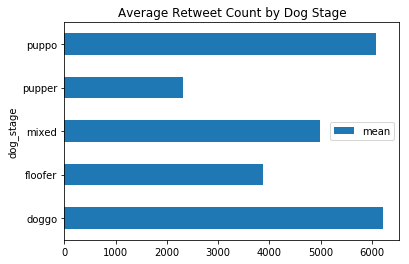

In [79]:
known_dog_stage.groupby('dog_stage')['retweet_count'].aggregate([np.mean]).plot(
    kind='barh', title='Average Retweet Count by Dog Stage')

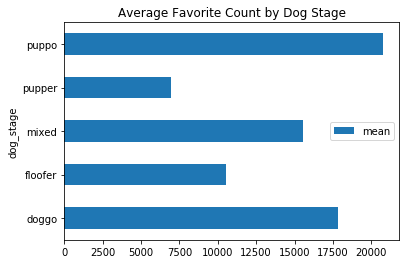

In [80]:
known_dog_stage.groupby('dog_stage')['favorite_count'].aggregate([np.mean]).plot(
    kind='barh',title='Average Favorite Count by Dog Stage')